# **Core Stock Data EDA for TSLA Ticker**
## In this notebook we will examine only the Tesla stock for the periods we have selected for this project (03-14-2019 through 08-15-2024), and see what we can derive from it through our plots.  We will look at each of our core stock tickers separately in order to gain a better analysis. 

#### Let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import gaussian_kde
import mplfinance as mpf

#### Now let's read in our data that we need for this notebook.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'core_stock_data.csv')
core_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
core_stock_data.head()

,Close_core,Volume_core,Open_core,High_core,Low_core,SMA_core,EMA_core,RSI_core,BBM_core,BBU_core,...,ATR_14_core,Stoch_K_core,Stoch_D_core,Momentum_1_core,Momentum_3_core,Momentum_7_core,Momentum_30_core,Momentum_50_core,OBV_core,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-14,45.932499,94318000,45.974998,46.025002,45.639999,41.35925,42.219051,75.741602,41.35925,46.695085,...,0.700179,97.465683,90.860103,0.504997,1.207500,2.049999,4.619999,7.049999,1592190800,AAPL
2019-03-15,46.529999,156171600,46.212502,46.832500,45.935001,41.50025,42.388107,76.985910,41.50025,47.003365,...,0.712679,93.213648,93.052540,0.597500,1.302498,2.899998,4.919998,7.049999,1748362400,AAPL
2019-03-18,47.005001,104879200,46.450001,47.097500,46.447498,41.72940,42.569162,78.724282,41.72940,47.174667,...,0.721072,98.041317,96.240216,0.475002,1.577499,3.880001,5.375000,11.457500,1853241600,AAPL
2019-03-19,46.632500,126585600,47.087502,47.247501,46.480000,41.92075,42.728509,73.527018,41.92075,47.369412,...,0.735358,87.378112,92.877692,-0.372501,0.700001,3.404999,3.820000,9.567501,1726656000,AAPL
2019-03-20,47.040001,124140800,46.557499,47.372501,46.182499,42.12190,42.897587,80.396901,42.12190,47.569044,...,0.784822,93.346666,92.922032,0.407501,0.510002,2.315002,3.495003,10.057503,1850796800,AAPL


In [3]:
# Now let's just select our subject stock information in the APPL stock.
tsla_data = core_stock_data[core_stock_data['Ticker'] == 'TSLA']
print(tsla_data.head())

            Close_core  Volume_core  Open_core  High_core   Low_core  \
Date                                                                   
2019-03-14   19.330667    106551000  19.496668  19.692667  19.219334   
2019-03-15   18.362000    221782500  18.900667  18.914667  18.293333   
2019-03-18   17.966000    154215000  18.400000  18.536667  17.820000   
2019-03-19   17.831333    177009000  17.833332  18.219999  17.563999   
2019-03-20   18.240000    103623000  17.979334  18.331333  17.753332   

             SMA_core   EMA_core   RSI_core   BBM_core   BBU_core  ...  \
Date                                                               ...   
2019-03-14  20.509440  20.114470  47.612353  20.509440  23.115269  ...   
2019-03-15  20.463187  20.045746  39.385122  20.463187  23.138226  ...   
2019-03-18  20.422027  19.964187  37.662004  20.422027  23.186485  ...   
2019-03-19  20.355067  19.880546  26.390952  20.355067  23.205506  ...   
2019-03-20  20.273253  19.816211  27.111773  20.273

#### Note above that the starting date is 03-14, this is because of the rolling windows when we calculated our SMA (Single Moving Average).  With our setting of 50 days for the window it was offset by the starting date of 01-01-2019, and we needed a whole window to compute.  So the date you see above in 03-14 starts a new window for us.

#### Let's begin our EDA analysis with a simple look at Closing price over time. 

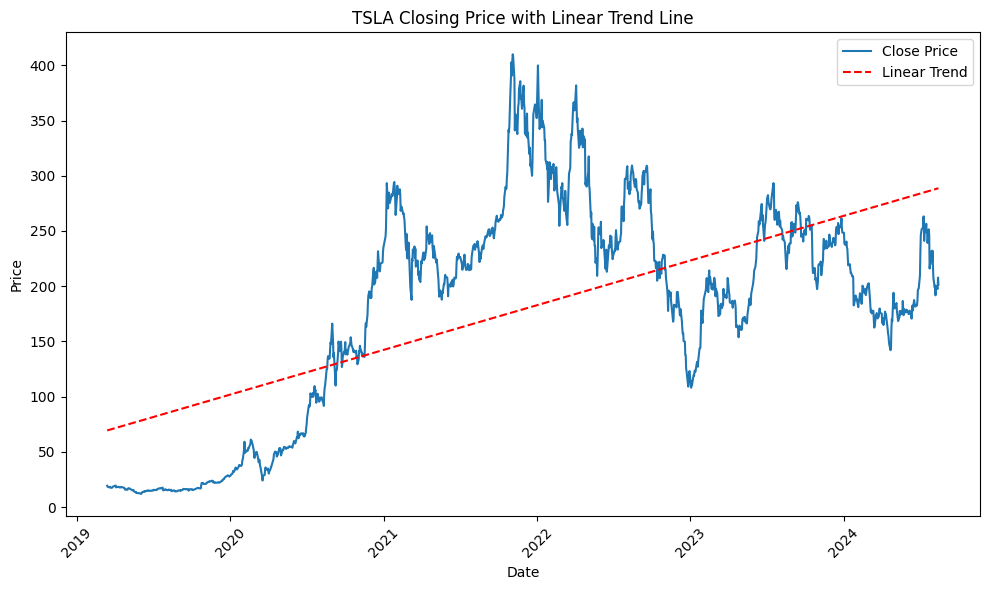

In [4]:
# Convert the dates to a numerical format (ordinal) for regression
tsla_data = tsla_data.copy()
tsla_data.loc[:, 'date_ordinal'] = tsla_data.index.map(pd.Timestamp.toordinal)

# Perform linear regression on date ordinals
slope, intercept, r_value, p_value, std_err = linregress(tsla_data['date_ordinal'], tsla_data['Close_core'])

# Calculate the regression line using the slope and intercept
tsla_data.loc[:, 'regression_line'] = slope * tsla_data['date_ordinal'] + intercept

# Plot the closing prices and the regression line
plt.figure(figsize=(10, 6))

# Plot close prices
sns.lineplot(x=tsla_data.index, y=tsla_data['Close_core'], label='Close Price')

# Plot the linear regression line
plt.plot(tsla_data.index, tsla_data['regression_line'], label='Linear Trend', color='red', linestyle='--')

# Set plot title and labels
plt.title('TSLA Closing Price with Linear Trend Line')
plt.xlabel('Date')
plt.ylabel('Price')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


#### Key Takeaways:  TSLA experienced fluctuation in pricing during our observation period.  Looking into historical events we can see:
#### (August 2020) Tesla announced a 5-for-1 stock split in August of 2020, which significantly boosted the stock price.

#### (December 2020) Tesla was officially added to the SP500 index at this time, and led to a massive increase in Tesla's stock price.

#### (2020 - 2021) The pandemic created significant volatility which affected their stock value.  Tesla still performed exceptionally well during this period.

#### Now let's look at Volume over the same period for TSLA.

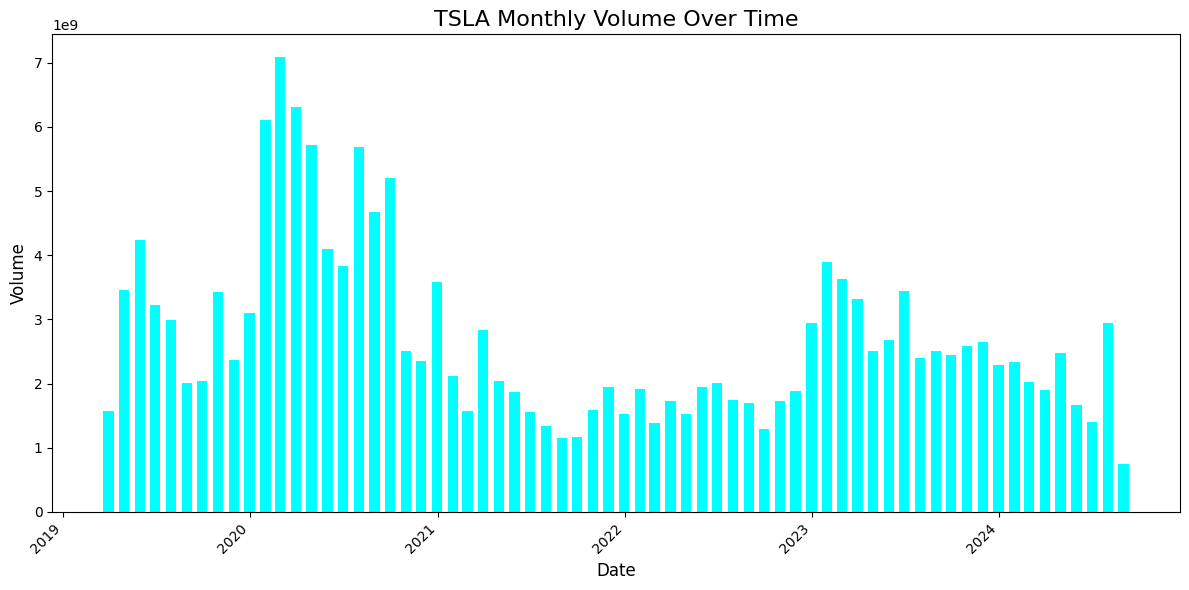

In [5]:
# Resample the data to monthly frequency ('ME' means month-end)
tsla_monthly = tsla_data.resample('ME').sum()

# Plot using Matplotlib
plt.figure(figsize=(12, 6))  # Larger figure size for better readability

# Plot the monthly volume as bars with better bar width
plt.bar(tsla_monthly.index, tsla_monthly['Volume_core'], color='cyan', width=20)

# Set the title and labels
plt.title('TSLA Monthly Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)

# Improve the x-axis tick appearance (rotate and format the dates)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display the plot with tight layout
plt.tight_layout()
plt.show()

#### Looking at the above monthly Volume for TSLA we can see a couple things.  The same time period for 2020 - 2021 again is noticeable, this time as TSLA's most positive trading period.  After 2020 the trading volume leveled off substantially to its lowest points within our viewing window, and after 2022 the trading volume rose back to norms through 2024.

#### Now let's look at the SMA and EMA (Simple Moving Average and Exponential Moving Average, respectively) for TSLA, to see what trends exist in this time period.

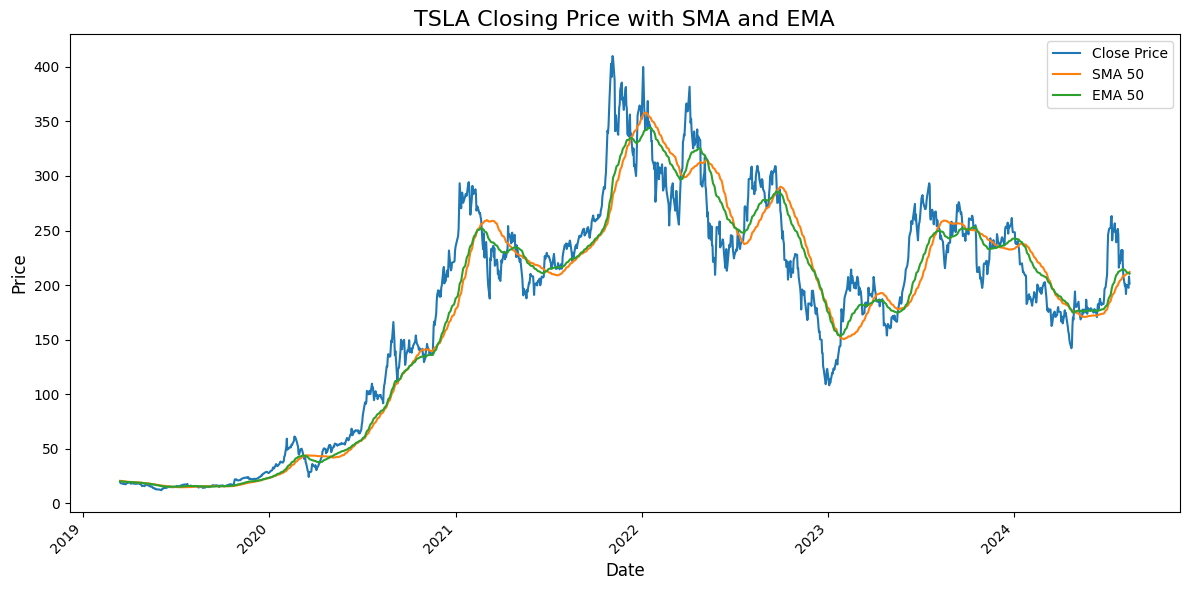

In [6]:
plt.figure(figsize=(12, 6))  # Larger figure for readability

# Plot the close price
sns.lineplot(x=tsla_data.index, y=tsla_data['Close_core'], label='Close Price')

# Plot the SMA if it exists
if 'SMA_core' in tsla_data.columns:
    sns.lineplot(x=tsla_data.index, y=tsla_data['SMA_core'], label='SMA 50')

# Plot the EMA if it exists
if 'EMA_core' in tsla_data.columns:
    sns.lineplot(x=tsla_data.index, y=tsla_data['EMA_core'], label='EMA 50')

# Set plot title and labels
plt.title('TSLA Closing Price with SMA and EMA', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add a legend
plt.legend()

# Display the plot with tight layout
plt.tight_layout()
plt.show()

#### Let's take a look at this one, as it introduces some new concepts.  Only looking at the SMA and EMA lines for a second (the red and the green lines) if both of them are sloping upwards it can indicate a short-term uptrend in the price and and confirm a bullish momentum.  We can clearly see this in several positions on our plot, notably in 2020 - 2022 (with some small declines in price throughout).  There are smaller examples but these two are the most obvious.  Conversely if these lines are together moving down then it can indicate a short-term downtrend or bearish momentum.

#### Now if the Closing Price is above our SMA and EMA lines then it indicates that the stock is trending above the recent average and shows suggested continued strength.  This can also be illustrated in the same periods noted above.

#### Looking at SMA vs EMA, if the SMA is *above* the EMA line this suggests that the the recent pricing is weaker and can indicate a price slow or momentum downshift.  Conversely if the EMA line is above the SMA line it can indicate a positive price shift and momentum upturn, which we can see the most clearly in Mar 23 - May 9 of 2022 and Jan 25 - Mar 27 of 2023.



#### Now let's look at our RSI (Relative Strength Index) for our TSLA data.

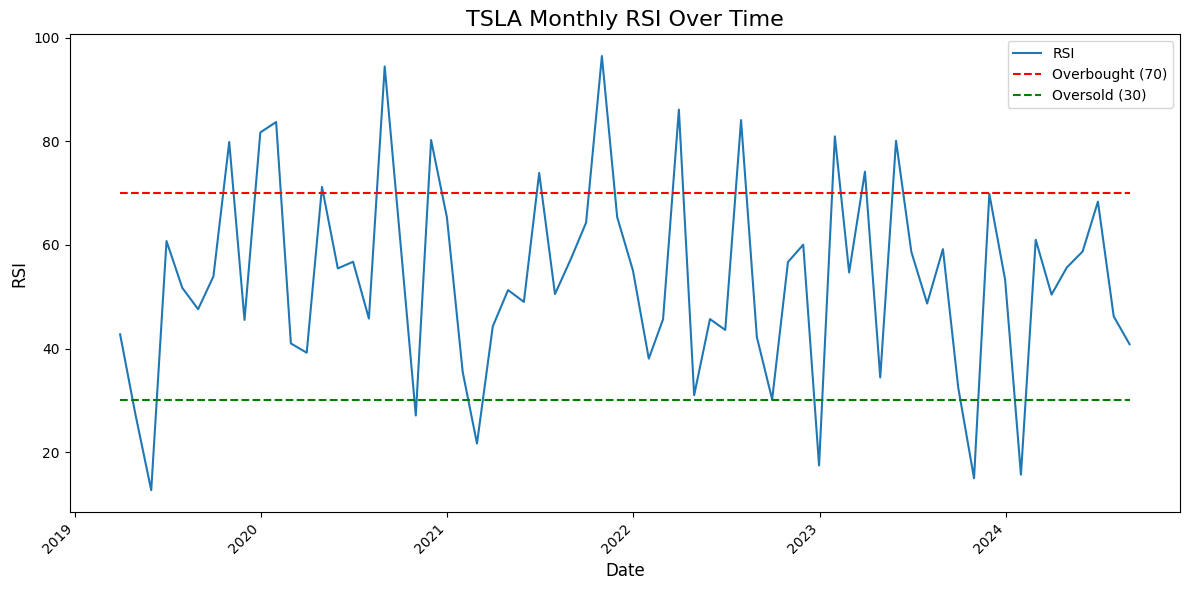

In [7]:
# Resample the data to monthly frequency ('ME' means month-end)
tsla_monthly = tsla_data.resample('ME').agg({
    'Close_core': 'last',
    'RSI_core': 'last'
})

plt.figure(figsize=(12, 6)) 

# Plot the RSI line
sns.lineplot(x=tsla_monthly.index, y=tsla_monthly['RSI_core'], label='RSI')

# Plot the Overbought line (70)
plt.plot(tsla_monthly.index, [70] * len(tsla_monthly), label='Overbought (70)', color='red', linestyle='--')

# Plot the Oversold line (30)
plt.plot(tsla_monthly.index, [30] * len(tsla_monthly), label='Oversold (30)', color='green', linestyle='--')

# Set plot title and labels
plt.title('TSLA Monthly RSI Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('RSI', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add a legend
plt.legend()

# Display the plot with tight layout
plt.tight_layout()
plt.show()



#### This plot above is very interesting as it can show us potential price shifts.  The red line for Overbought indicates that while the price has been strong it could be due for a reversal or a decrease.  You can see this happen multiple times over this plot with the sudden spike over the red line, then a quick dip back below.  This can take a while to happen, but eventually does.

#### Let's also look at the Oversold line.  Similarly to the Overbought line this line indicates when a positive shift in price is about to happen.  So when the RSI value dips below the green line the signs point toward an increase in pricing.  This can also be viewed in the plot numerous times, especially in Jan - Feb of 2021 and Sept - Oct of 2023.

#### Now let's make use of some of the other features in our dataset and make a Candlestick Chart.

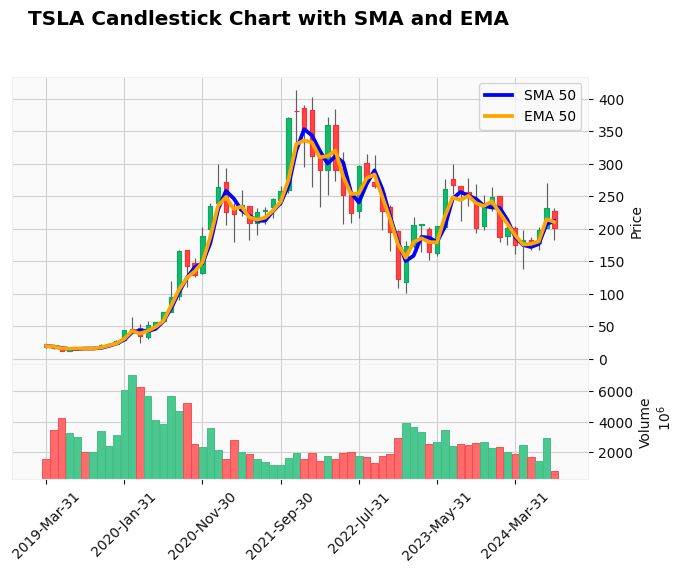

In [8]:
# Resample the data to monthly frequency ('ME' means month-end)
tsla_monthly_candles = tsla_data.resample('ME').agg({
        'Open_core': 'first',
        'High_core': 'max',
        'Low_core': 'min',
        'Close_core': 'last',
        'Volume_core': 'sum',
        'SMA_core': 'last',
        'EMA_core': 'last'
})

# Preparing the data for mplfinance (it requires OHLC data with a specific format)
tsla_monthly_candles_mpf = tsla_monthly_candles[['Open_core', 'High_core', 'Low_core', 'Close_core', 'Volume_core']]

# Rename the columns to match mplfinance expectations
tsla_monthly_candles_mpf.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Plot the candlestick chart with mplfinance
mpf.plot(tsla_monthly_candles_mpf, type='candle', style='yahoo', 
        title='TSLA Candlestick Chart with SMA and EMA', 
        ylabel='Price', 
        addplot=[mpf.make_addplot(tsla_monthly_candles['SMA_core'], color='blue', label='SMA 50'),
                mpf.make_addplot(tsla_monthly_candles['EMA_core'], color='orange', label='EMA 50')],
        volume=True, ylabel_lower = 'Volume')

plt.show()






#### Candlestick charts are great at showing a lot of information.  The size of the candle shows the range of pricing in the given window, in our case a month.  The color (green for positive change, red for negative) will dictate how the final closing price was settled (final closing - beginning opening price for the total window, again a month here).  

#### You can then begin to see trends just by noticing the colors, although there are other parts of the candlestick too.  You can notice buyer/seller behavior by looking at successive green or red candlesticks.  If you see multiple long red candlesticks together it could mean that sellers are pushing prices lower.  This can be demonstrated in TSLA from Nov 2021 - Mar 2022.  Conversely successive green candlesticks can show buyer behavior pushing positive price changes.  This can be show in several places, especially from Apr - Aug of 2020.  

#### Now let's look at a correlation heatmap to see which indicators are most closely related to price movements for our TSLA stock.

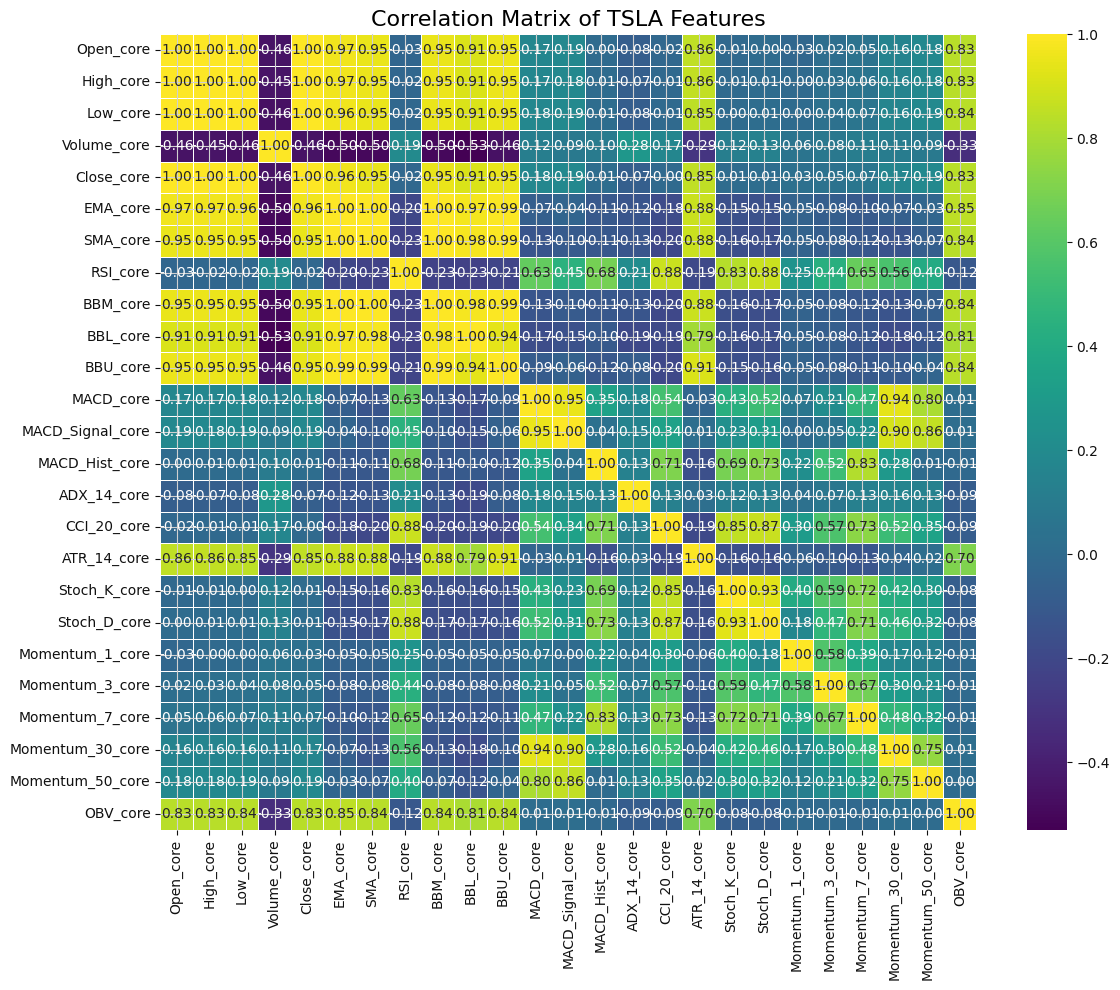

In [9]:
# Calculate the correlation matrix
corr_matrix = tsla_data[['Open_core', 'High_core', 'Low_core', 'Volume_core', 'Close_core', 'EMA_core', 'SMA_core', 'RSI_core', 'BBM_core', 'BBL_core', 'BBU_core', 'MACD_core', 'MACD_Signal_core', 'MACD_Hist_core', 'ADX_14_core', 'CCI_20_core', 'ATR_14_core', 'Stoch_K_core', 'Stoch_D_core', 'Momentum_1_core', 'Momentum_3_core', 'Momentum_7_core', 'Momentum_30_core', 'Momentum_50_core', 'OBV_core']].corr()

# Create a figure and axis
plt.figure(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5, fmt=".2f")

# Set the title
plt.title('Correlation Matrix of TSLA Features', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()

#### For the above correlation plot we are looking at which features correlate the strongest with our Close price, as that is going to be our strongest driver for this project.  Looking at our colorbar a score of 1 is very strong, and this chart shows that our  EMA_core and SMA_core have very strong correlations with our Close Price, as do all of the Bollinger Band features.  We will look to capitalize on these correlations later on.

#### Now let's look at a distribution of daily returns for TSLA.

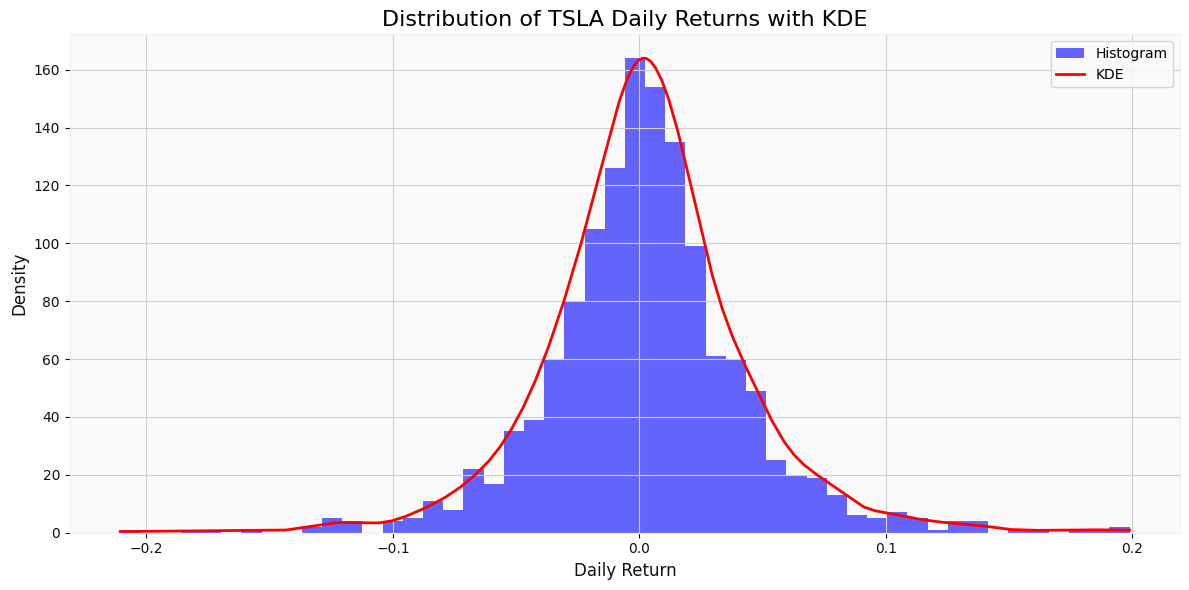

In [10]:
# Calculating the daily returns
tsla_data['daily_return'] = tsla_data['Close_core'].pct_change()

# Drop NaN values for the daily returns
daily_returns = tsla_data['daily_return'].dropna()

# Calculate the KDE for the daily returns
kde = gaussian_kde(daily_returns)
x_vals = np.linspace(daily_returns.min(), daily_returns.max(), 1000)
kde_vals = kde(x_vals)

# Plotting the histogram of daily returns
plt.figure(figsize=(12, 6))

# Plot the histogram of daily returns without the KDE
hist_values, bin_edges, _ = plt.hist(daily_returns, bins=50, color='blue', alpha=0.6, label='Histogram', density=False)

# Scale the KDE to match the histogram's max frequency
scaling_factor = max(hist_values) / max(kde_vals)
kde_vals_scaled = kde_vals * scaling_factor

plt.plot(x_vals, kde_vals_scaled, color = 'red', label = 'KDE', linewidth = 2)

# Set plot title and labels
plt.title('Distribution of TSLA Daily Returns with KDE', fontsize=16)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add a legend
plt.legend()

# Display the plot with tight layout
plt.tight_layout()
plt.show()




#### There are some key takeaways from our distribution chart.  The first one is that the distribution is mostly centered around 0, with very little spread from the center.  With this near symmetry it suggests that positive and negative are both likely and that there is no strong bias in the direction of the returns.  Also with it being a normal distribution it shows that our TSLA stock behaves in a predictable manner, where extreme returns are rare.  The minimal spread (distance away from 0) indicates low volatility as well.  

#### Let's now look at a Rolling Mean and Volatility plot.  We will use this to understand the stability of price movements over time, as it is helpful to identify periods of high uncertainty and/or strong trends in our pricing.

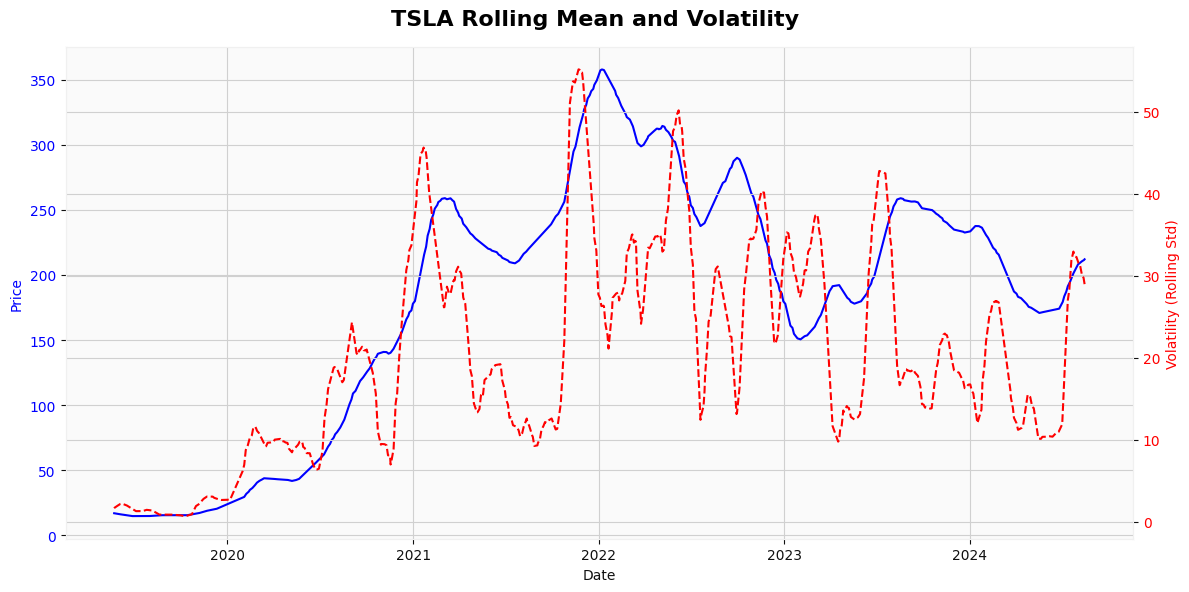

In [11]:
#### First let's create the rolling mean and rolling std needed for this plot.
#### We will keep the same window size as our SMA and EMA windows for consistency and to also help us as we view the long-term analysis.
tsla_data.loc[:, 'Rolling_Mean'] = tsla_data['Close_core'].rolling(window = 50).mean()
tsla_data.loc[:, 'Rolling_Std'] = tsla_data['Close_core'].rolling(window = 50).std()

# Create a figure and axis with a secondary y-axis for the rolling standard deviation (volatility)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the rolling mean on the primary y-axis
ax1.plot(tsla_data.index, tsla_data['Rolling_Mean'], label='Rolling Mean', color='blue')

# Set the labels for the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the rolling standard deviation (volatility)
ax2 = ax1.twinx()

# Plot the rolling standard deviation (volatility) on the secondary y-axis
ax2.plot(tsla_data.index, tsla_data['Rolling_Std'], label='Rolling Std (Volatility)', color='red', linestyle='--')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Volatility (Rolling Std)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set plot title and add a legend for both axes
fig.suptitle('TSLA Rolling Mean and Volatility', fontsize=16)

# Display the plot with tight layout
fig.tight_layout()
plt.show()

#### In this plot above we can see again the general price increase over time in the blue line that is the Rolling Mean.  Our previous plots have shown this as well a bit this is just more reinforcement and a bit more demonstrative of that fact.  The red line in the Rolling Std is a bit more important as it displays Volatility.  Our window size of 50 days plays a part in this too as it will smooth out short-term volatility and provide a longer-term view of that price stability.  As we can see the price for TSLA is extremely unstable, with some of the highest overall volatility over the timeframe.

#### We will now look at a few of the plots whose features correlated most closely with our target Price.  We will take these last few plots and look at some Bollinger Bands and On-Balance Volume for our TSLA data.

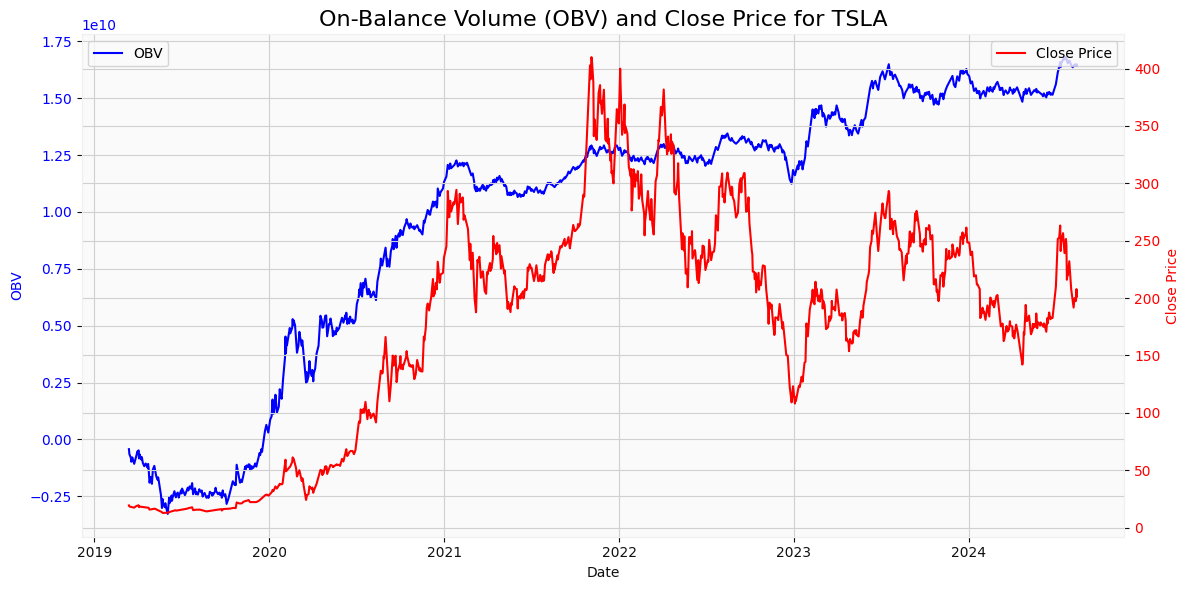

In [12]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the OBV on the primary y-axis
ax1.plot(tsla_data.index, tsla_data['OBV_core'], label='OBV', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('OBV', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the Close Price
ax2 = ax1.twinx()
ax2.plot(tsla_data.index, tsla_data['Close_core'], label='Close Price', color='red')
ax2.set_ylabel('Close Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title
plt.title("On-Balance Volume (OBV) and Close Price for TSLA", fontsize=16)

# Add legends for both lines
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot with tight layout
fig.tight_layout()
plt.show()

#### OBV (On-Balance Volume) can provide valuable insights into the relationship between price movements and trading volume.  We can show the confirmation of the trend when the OBV line is moving in the same direction as the Price line (for the second half of the plot mostly) as it would suggest that the price trend is backed by the volume, indicating the momentum direction.
#### OBV often acts as a leading indicator and predictor of the Price, however you can see above in large portions of the plot there is no mirrored movement to our Price from the OBV line except for partial slope mirror in 2020.  This just shows that the TSLA stock is very unpredictable and backs up its high volatility. 

#### For our last plot in our EDA notebook we will look at all 3 of the Bollinger Bands with a Close price overlay.  The Bollinger Bands were our other high correlator in our correlation matrix above.  Let's see what we can derive from it.

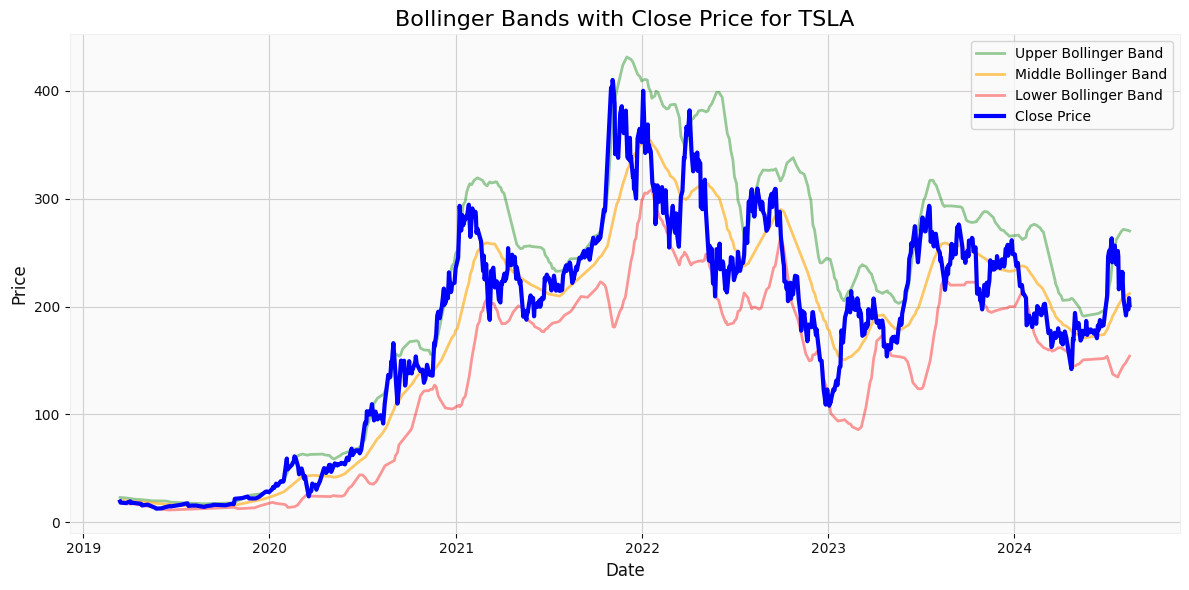

In [13]:
# Create the figure and axis
plt.figure(figsize=(12, 6))

# Plot the Upper Bollinger Band
plt.plot(tsla_data.index, tsla_data['BBU_core'], label='Upper Bollinger Band', color='green', linewidth=2, alpha=0.4)

# Plot the Middle Bollinger Band (BBM)
plt.plot(tsla_data.index, tsla_data['BBM_core'], label='Middle Bollinger Band', color='orange', linewidth=2, alpha=0.6)

# Plot the Lower Bollinger Band (BBL)
plt.plot(tsla_data.index, tsla_data['BBL_core'], label='Lower Bollinger Band', color='red', linewidth=2, alpha=0.4)

# Plot the Close Price
plt.plot(tsla_data.index, tsla_data['Close_core'], label='Close Price', color='blue', linewidth=3)

# Set the plot title and labels
plt.title("Bollinger Bands with Close Price for TSLA", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Add the legend
plt.legend()

# Display the plot with tight layout
plt.tight_layout()
plt.show()

#### The above Bollinger Bands plot with Closing Price combines a lot of features and information we have seen in this notebook to give a clear picture of the stock data and whether it is relatively high or low.  The Close price will oscillate between the Upper and Lower bands (Green and Red, respectively).  Now when the Close Price touches these bands and moves through it, this can indicate Overbought or Oversold conditions (much like our RSI plot above).
#### The width of the bands can also show volatility, where a wider band visual indicates increased volatility and conversely shortened or decreased band width can indicated less volatility for that time period.
#### What to look out for is when the Price does indeed break outside of the bands, as that is when something unique or unusual is happening.  In the above while the Price for TSLA touches the outside bands multiple times, TSLA's price only exceeds the bands a few times: Oct 15 - Nov 8 of 2021, and Jun 2 - 21 of 2023 amongst others.  

## Summary of Findings for TSLA
#### We have taken a good look at our TSLA stock covering the given time period.  Here is some of the key takeaways from our plots:

#### -TSLA Stock Price has shown to be an extremely inconsistent performer with very high volatility.
#### -TSLA's Closing Price is strongly correlated with the SMA (Single Moving Average) and EMA (Exponential Moving Average) as well as Bollinger Band features.
#### -TSLA's price behaves in a  pretty unpredictable manner, though future modeling may be able to get a hold of it.